# Lets create a Recommendation system for the Henry coefficients of porous materials

In [7]:
import json
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import pprint
import os
import scipy
import matplotlib

## We will use the Henry Coefficient matrix, created in `HenryMatrix.ipynb`

In [2]:
henry_df = pd.read_csv('data/henry_matrix_df.csv')
henry_df.set_index(list(henry_df)[0], inplace=True)
henry_df.head(10)

,CURLTUGMZLYLDI-UHFFFAOYSA-N_298K,IJGRMHOSHXDMSA-UHFFFAOYSA-N_298K,VNWKTOKETHGBQD-UHFFFAOYSA-N_298K,MYMOFIZGZYHOMD-UHFFFAOYSA-N_298K,QQONPFPTGQHPMA-UHFFFAOYSA-N_298K,ATUOYWHBWRKTHZ-UHFFFAOYSA-N_298K,HSFWRNGVRCDJHI-UHFFFAOYSA-N_298K,UFHFLCQGNIYNRP-UHFFFAOYSA-N_298K,FHNFHKCVQCLJFQ-UHFFFAOYSA-N_298K,DNNSSWSSYDEUBZ-UHFFFAOYSA-N_298K,...,IJDNQMDRQITEOD-UHFFFAOYSA-N_298K,NNPPMTNAJDCUHE-UHFFFAOYSA-N_298K,KFZMGEQAYNKOFK-UHFFFAOYSA-N_298K,BDERNNFJNOPAEC-UHFFFAOYSA-N_298K,YXFVVABEGXRONW-UHFFFAOYSA-N_298K,OFBQJSOFQDEBGM-UHFFFAOYSA-N_298K,URLKBWYHVLBVBO-UHFFFAOYSA-N_298K,RAHZWNYVWXNFOC-UHFFFAOYSA-N_298K,SWQJXJOGLNCZEY-UHFFFAOYSA-N_298K,VXNZUUAINFGPBY-UHFFFAOYSA-N_298K
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
NIST-MATDB-b2dc02871a66ac38e4b195796cf3e00b,2.008819,0.643667,1.488271,NaN,12.326242,13.901850,0.001502,4.278958,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,184.515123,18.192574,NaN,NaN
NIST-MATDB-035dc75dddd00241bd76627f78cbef2d,19.028379,1.164261,2.365370,0.207510,52.095266,80.817935,NaN,NaN,NaN,NaN,...,277.462875,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000427,86.730874
NIST-MATDB-453276ee992ed07dc207ed08b2b221ce,2.627486,0.358104,3.818254,0.188162,NaN,NaN,NaN,2.870710,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NIST-MATDB-1b85b1862d4e9cc2e0f46d0e2698ab79,2.829608,3.560541,1.161928,0.097778,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2545.488327,NaN,NaN,NaN
NIST-MATDB-991daf7313251e7e607e2bab2da57e33,4.219215,1.608393,0.735890,0.198392,801.831703,37.161951,66.660252,2.980532,20.891916,NaN,...,162.552306,523.199397,NaN,NaN,NaN,5039.506512,NaN,94.944295,NaN,NaN
NIST-MATDB-9f02824618e94d86caedc9fb497366ba,0.519875,NaN,0.003670,NaN,NaN,NaN,5.888583,4.531390,NaN,NaN,...,866.240937,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NIST-MATDB-acbbe796d49416e999dc819f2ae65fe9,3.187140,NaN,NaN,NaN,NaN,NaN,51.060147,7.839395,1.624859,0.794992,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55.104883,NaN,NaN
NIST-MATDB-2c9380bddc59f547484ff729eab7d7cb,4.713414,0.246910,3.270094,NaN,NaN,0.219119,1.156680,2.841091,2.704463,0.469957,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.823514,NaN,NaN
NIST-MATDB-5ab0dbe0639729711750ef4b97715f0f,3.342682,4.399035,0.558434,0.122395,NaN,NaN,NaN,0.720796,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
#Creates a dictionary of InChIKeys to gas names (and gas names to InChIKeys)
host = "adsorption.nist.gov"
url = "https://" + host + "/isodb/api/gases.json"
gas_data = json.loads(requests.get(url).content)

key_to_gas = {}
for gas in gas_data:
    key_to_gas[gas['InChIKey']] = gas['name']
gas_to_key = dict(map(reversed, key_to_gas.items()))

#Creates a dictionary for hashkeys to material names (and material names to hashkeys)
url = "https://" + host + "/isodb/api/materials.json"
material_data = json.loads(requests.get(url).content)

key_to_material = {}
for material in material_data:
    key_to_material[material['hashkey']] = material['name']
material_to_key = dict(map(reversed, key_to_material.items()))

## Lets also define a function that will randomly split our data into <i>k</i> folds

In [4]:
def k_fold_split(henry_df, k, max_iter=1000):
    assert k > 1, 'Choose a `k` greater than 1, otherwise this function is pointless'
    matrix = henry_df.values
    fold_matrix = np.full_like(matrix, -1, dtype=np.int)
    all_k_folds_not_represented_in_each_column = True
    n_iteration = 0
    while all_k_folds_not_represented_in_each_column:
        n_iteration += 1
        all_k_folds_not_represented_in_each_column = False
        for i_row in range(matrix.shape[0]):
            # Grabs all available indices in row `i_row`
            j_indices = np.where(~np.isnan(matrix[i_row,:]))[0]
            # As long as there are enough data points to distribute between `k` folds, we'll equally distribute them.
            while len(j_indices) >= k:
                for fold in range(k):
                    j = np.random.randint(0, len(j_indices))
                    fold_matrix[i_row, j_indices[j]] = fold
                    j_indices = np.delete(j_indices, j)
            # If there are leftover data points (i.e. #data points left < `k`), we'll randomly assign them into folds
            for j in j_indices:
                fold_matrix[i_row, j] = np.random.randint(0, k)
        # We make sure we have enough data points in the columns as well
        for j_col in range(matrix.shape[1]):
            unique_folds = np.unique(fold_matrix[:, j_col])
            #print(len(vals[~np.isnan(vals)]))
            if len(unique_folds) <= k:
                all_k_folds_not_represented_in_each_column = True
                break
        # If too many iteration are performed an Exception is raised.
        if n_iteration > max_iter:
            raise Exception('Maximum number of iterations reached. Try changing the `max_iter` argument.')
    
    print('Number of iterations required to split data into {}-folds: {}'.format(k, n_iteration))
    return fold_matrix

fold_matrix = k_fold_split(henry_df, 3, max_iter=1e5)

Number of iterations required to split data into 3-folds: 42


In [5]:
def sort_matrix_by_freq(material_gas_matrix):
    row_sum = np.sum(material_gas_matrix, axis=1)
    old_row_order = np.arange(len(row_sum))
    new_row_order = sorted(old_row_order, key=lambda x: row_sum[x], reverse=True)
    col_sum = np.sum(material_gas_matrix[new_row_order, :], axis=0)
    old_col_order = np.arange(len(col_sum))
    new_col_order = sorted(old_col_order, key=lambda x: col_sum[x], reverse=True)
    return material_gas_matrix[new_row_order, :][:, new_col_order]

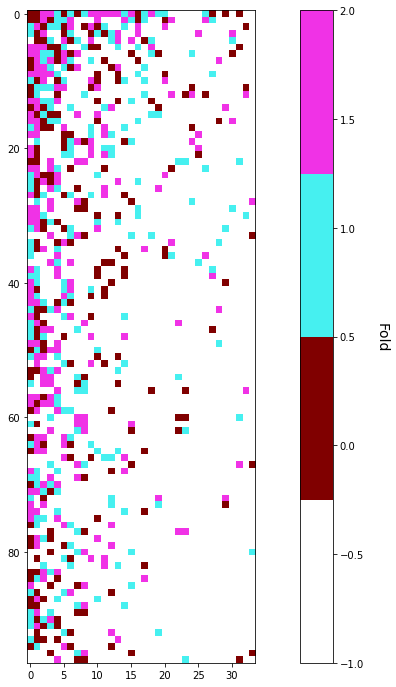

In [8]:
fig = plt.figure(figsize=(16,12))
ax = plt.gca()
#my_cmap = matplotlib.cm.get_cmap('Accent')
mycmap = matplotlib.colors.ListedColormap(np.array([[255/255, 255/255, 255/255, 1], 
                                                    [128/255, 0, 0, 1], 
                                                    [70/255, 240/255, 240/255, 1], 
                                                    [240/255, 50/255, 230/255, 1],
                                                    [60/255, 180/255, 75/255, 1],
                                                    [245/255, 130/255, 48/255, 1]][:len(np.unique(fold_matrix))]))
plt.imshow(sort_matrix_by_freq(fold_matrix), interpolation='none', cmap=mycmap)
cbar = plt.colorbar()
cbar.set_label('Fold', fontsize=14, rotation=270, labelpad=25)
#ax.axis('auto')

plt.show()

In [9]:
henry_df.mask(fold_matrix != 0).values

array([[       nan, 0.64366743,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan, 2.36537013, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [       nan,        nan, 0.65400275, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]])

### Lets start setting up the Recommender System algorithm

In [10]:
def predict(x, y, mu, b_i, b_u):
    #print('x shape: {}, y shape: {}'.format(x.shape, y.shape))
    return mu + b_i + b_u + (x.T).dot(y)

In [11]:
def predict_all(X, Y, mu, b_i, b_u):
    predictions = np.zeros((X.shape[1], Y.shape[1]))
    for u in range(X.shape[1]):
        for i in range(Y.shape[1]):
            predictions[u, i] = predict(X[:,u], Y[:,i], mu, b_i[i], b_u[u])
    return predictions

#### ALS methods implemented according to http://stanford.edu/~rezab/classes/cme323/S15/notes/lec14.pdf

X_shape: (20, 97)	Y_shape: (20, 34)
Train Error on iteration 0: 70.8129263280951
-------------
Train Error on iteration 1000: 1.9826958847468819
-------------
Training has converged after 1494 iterations. See `convergence` parameter for convergence procedure.
Train error: 1.9933886178387008


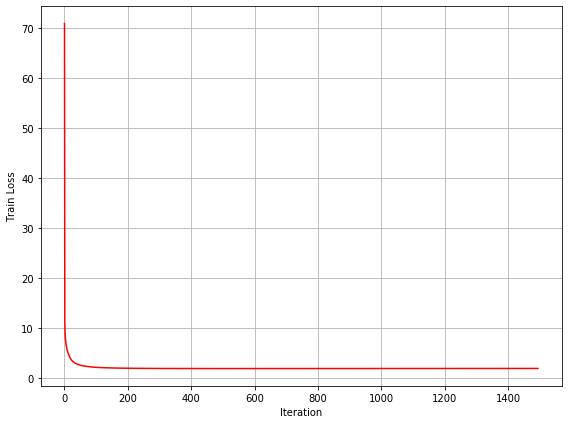

In [12]:
def ALS(henry_matrix, f, lambd, threshold, convergence=1e-5, verbose=True):
    n = 0
    train_error_arr = []
    train_error = np.inf
    prev_error = 0
    convergence_cnt = 0
    mu = np.nanmean(henry_matrix)
    b_i = np.nanmean(henry_matrix, axis=0) - mu
    b_u = np.nanmean(henry_matrix, axis=1) - mu
    
    M = (np.random.rand(f, henry_matrix.shape[0])-0.5)*0.1
    G = (np.random.rand(f, henry_matrix.shape[1])-0.5)*0.1
    print('X_shape: {}\tY_shape: {}'.format(M.shape, G.shape))
    while train_error > threshold:
        for j in range(M.shape[1]):
            B = mu + b_u[j] + b_i
            mask = ~np.isnan(henry_matrix[j,:])
            try:
                z = np.linalg.inv(G[:,mask].dot(G[:,mask].T) + lambd * np.identity(f))
            except Exception as e:
                print(G[:,mask].dot(G[:,mask].T))
                raise Exception(e)
            M[:,j] = ((henry_matrix[j,:][mask]-B[mask]).dot(G[:,mask].T)).dot(np.linalg.inv(G[:,mask].dot(G[:,mask].T) + lambd * np.identity(f)))
        for j in range(G.shape[1]):
            B = mu + b_i[j] + b_u
            mask = ~np.isnan(henry_matrix[:,j])
            G[:,j] = np.linalg.inv(M[:,mask].dot(M[:,mask].T) + lambd * np.identity(f)).dot(M[:,mask]).dot(henry_matrix[:,j][mask]-B[mask])
                
        #print(tf.math.subtract(henry_matrix, tf.matmul(np.transpose(X), Y)))
        pred = predict_all(M, G, mu, b_i, b_u)[~np.isnan(henry_matrix)].flatten()
        actual = henry_matrix[~np.isnan(henry_matrix)].flatten()
        #print(pred)
        prev_error = train_error
        train_error = np.sqrt(np.sum([(actual[i] - pred[i])**2 for i in range(len(pred))])/len(pred))
        train_error_arr.append(train_error)
        error_diff = prev_error - train_error
        if n % 1000 == 0:
            print('Train Error on iteration {}: {}\n-------------'.format(n, train_error))
            
        if error_diff < convergence:
            convergence_cnt += 1
            if convergence_cnt > 999:
                print('Training has converged after {} iterations. See `convergence` parameter for convergence procedure.'.format(n))
                print('Train error: {}'.format(train_error))
                break
        else:
            convergence_cnt = 0
        n += 1
    
    fig, ax = plt.subplots(figsize=(8,6))
    #ax.scatter(np.arange(len(train_error_arr)), train_error_arr, color='red')
    ax.plot(np.arange(len(train_error_arr)), train_error_arr, color='red')
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Train Loss')
    plt.grid('on')
    plt.tight_layout()
    plt.show()
    
    return M, G, mu, b_i, b_u
p,q,mu,b_i,b_u = ALS(henry_df.values, 20, 10.3, 1e-5)

In [15]:
h = p.T.dot(q)
#i = random.choice(np.arange(henry_df.shape[0]))
#j = random.choice(np.arange(henry_df.shape[1]))
_i,_j = np.where(~np.isnan(henry_df.values))
for _ in range(10):
    idx = random.choice(np.arange(len(_i)))
    i = _i[idx]
    j = _j[idx]
    print('Adsorption of {} in {}'.format(key_to_gas[henry_df.columns[j].split('_')[0]], key_to_material[henry_df.index[i]]))
    print('Prediction: {}'.format(h[i,j] + mu + b_i[j] + b_u[i]))
    print('Actual value: {}\n'.format(henry_df.values[i,j]))

Adsorption of Ethane in NOTT-300
Prediction: 0.48554705033348
Actual value: 0.7301105427796805

Adsorption of Carbon Dioxide in CID-3
Prediction: 5.097617444413004
Actual value: 4.15556656215738

Adsorption of Oxygen in UiO-66
Prediction: -0.9599446714894384
Actual value: 0.12239501054837043

Adsorption of Methane in ZIF-71
Prediction: -1.03260647585887
Actual value: 0.4441664384630852

Adsorption of Acetone in [Co3(ndc)-(HCOO)3(mu3-OH)(H2O)]n
Prediction: 481.84225822657027
Actual value: 486.8087607895575

Adsorption of Cyclohexane in C62H50Cd3K2N2O26
Prediction: 99.0539777691738
Actual value: 95.24745473600744

Adsorption of N-propane in MIL-53(Fe)
Prediction: 0.2675219490024574
Actual value: 0.07864598854188405

Adsorption of Methane in MIL-47
Prediction: 0.7964454853258758
Actual value: 0.6833043875886337

Adsorption of Ethene in NOTT-300
Prediction: 7.299101670864616
Actual value: 7.205223216306435

Adsorption of Ethane in Zn-DABCO
Prediction: 5.2180778430343935
Actual value: 4.899

In [16]:
def predict_v2(x, y, mu):
    #print('x shape: {}, y shape: {}'.format(x.shape, y.shape))
    return mu + (x.T).dot(y)

In [17]:
def predict_all_v2(X, Y, mu):
    predictions = np.zeros((X.shape[1], Y.shape[1]))
    for u in range(X.shape[1]):
        for i in range(Y.shape[1]):
            predictions[u, i] = predict_v2(X[:,u], Y[:,i], mu)
    return predictions

M shape: (9, 97)	G shape: (9, 34)
Train Error on iteration 0: 1411.3005690804341
-------------
Training has converged after 559 iterations. See `convergence` parameter for convergence procedure.
Train error: 2748.012654618492


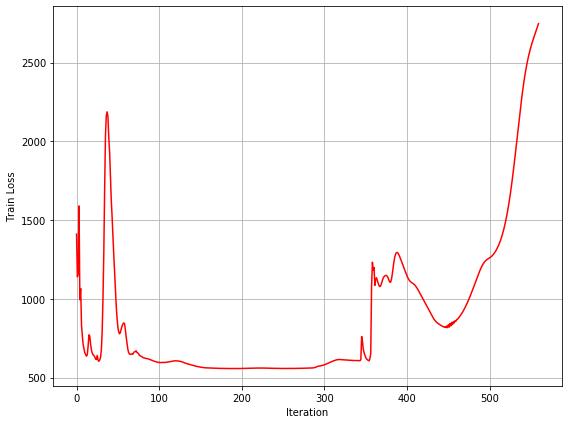

In [18]:
def ALS_v2(henry_matrix, f, lambd, threshold, convergence=1e-5, maxiter=20000, verbose=True):
    assert len(lambd) == 2, "There should be two lambda values, one for each latent matrix"
    n = 0
    train_error_arr = []
    train_error = np.inf
    prev_error = 0
    convergence_cnt = 0
    
    M = np.random.rand(f+2, henry_matrix.shape[0])
    G = np.random.rand(f+2, henry_matrix.shape[1])
    M[-2,:] = 1.0
    G[-1,:] = 1.0
    print('M shape: {}\tG shape: {}'.format(M.shape, G.shape))
    while train_error > threshold:
        for j in range(M.shape[1]):
            mask = ~np.isnan(henry_matrix[j,:])
            M[:,j] = ((henry_matrix[j,:][mask]).dot(G[:,mask].T)).dot(np.linalg.inv(G[:,mask].dot(G[:,mask].T) + lambd[0] * np.identity(f+2)))
            M[-2,j] = 1.0
        for j in range(G.shape[1]):
            mask = ~np.isnan(henry_matrix[:,j])
            G[:,j] = np.linalg.inv(M[:,mask].dot(M[:,mask].T) + lambd[1] * np.identity(f+2)).dot(M[:,mask]).dot(henry_matrix[:,j][mask])
            G[-1,j] = 1.0
            
        #print(tf.math.subtract(henry_matrix, tf.matmul(np.transpose(X), Y)))
        pred = predict_all_v2(M, G, mu)[~np.isnan(henry_matrix)].flatten()
        actual = henry_matrix[~np.isnan(henry_matrix)].flatten()
        #print(pred)
        prev_error = train_error
        train_error = np.sqrt(np.sum([(actual[i] - pred[i])**2 for i in range(len(pred))])/len(pred))
        train_error_arr.append(train_error)
        error_diff = prev_error - train_error
        if n % 1000 == 0:
            print('Train Error on iteration {}: {}\n-------------'.format(n, train_error))
            
        if error_diff < convergence:
            convergence_cnt += 1
            if convergence_cnt > 99:
                print('Training has converged after {} iterations. See `convergence` parameter for convergence procedure.'.format(n))
                print('Train error: {}'.format(train_error))
                break
        else:
            convergence_cnt = 0
        n += 1
        if n > maxiter:
            print('Maximum number of iterations reached.')
            break
    
    fig, ax = plt.subplots(figsize=(8,6))
    #ax.scatter(np.arange(len(train_error_arr)), train_error_arr, color='red')
    ax.plot(np.arange(len(train_error_arr)), train_error_arr, color='red')
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Train Loss')
    plt.grid('on')
    plt.tight_layout()
    plt.show()
    
    return M, G
mu = np.nanmean(henry_df.values)
M,G = ALS_v2(henry_df.values - mu, 7, [0.3, 2.4], 1e-4)

In [23]:
h = M.T.dot(G) + mu
#i = random.choice(np.arange(henry_df.shape[0]))
#j = random.choice(np.arange(henry_df.shape[1]))
_i,_j = np.where(~np.isnan(henry_df.values))
for _ in range(10):
    idx = random.choice(np.arange(len(_i)))
    i = _i[idx]
    j = _j[idx]
    print('Adsorption of {} in {}'.format(key_to_gas[henry_df.columns[j].split('_')[0]], key_to_material[henry_df.index[i]]))
    print('Prediction: {}'.format(h[i,j]))
    print('Actual value: {}\n'.format(henry_df.values[i,j]))

Adsorption of Toluene in C115.5H202N14O43Zn4
Prediction: 20.571316689161904
Actual value: 7.6506159760719745

Adsorption of Hydrogen in 467-MOF
Prediction: 0.49841390378367123
Actual value: 0.11028732936602252

Adsorption of Sulfur Hexafluoride in Zeolite 13X
Prediction: 14.76037165858736
Actual value: 14.68311113116128

Adsorption of Ammonia in Mg-MOF-74
Prediction: 174.96940126173723
Actual value: 174.5403766124208

Adsorption of Hydrogen in NOTT-202a
Prediction: 0.7349924829455858
Actual value: 0.6645797051462696

Adsorption of N-propane in [Co2(ndc)2(bpy)]
Prediction: 5.0133620407585795
Actual value: 4.3155065998919735

Adsorption of Carbon Dioxide in Y-ftw-MOF-2
Prediction: 36.851271373391
Actual value: 1.1042904887630578

Adsorption of Carbon Dioxide in IRMOF-1
Prediction: -14.127586976987914
Actual value: 4.7134135165552475

Adsorption of N-Pentane in CuBTC
Prediction: 5023.941729338701
Actual value: 5039.506511759406

Adsorption of Methanol in C62H50Cd3K2N2O26
Prediction: 3239.

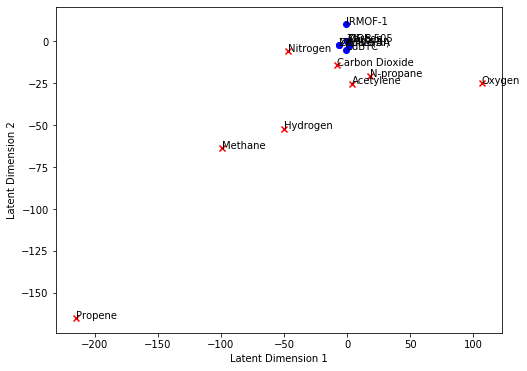

In [24]:
fig, ax = plt.subplots(figsize=(8,6))
n = 8
ax.scatter(M[0,:n], M[1,:n], color='red', marker='x')
ax.scatter(G[0,:n], G[1,:n], color='blue', marker='o')
ax.set_xlabel('Latent Dimension 1')
ax.set_ylabel('Latent Dimension 2')

for i in range(n):
    ax.text(M[0,i], M[1,i], key_to_gas[henry_df.columns[i].split('_')[0]])
    ax.text(G[0,i], G[1,i], key_to_material[henry_df.index[i]])
plt.show()

In [25]:
p.shape

(20, 97)

In [26]:
def predict_v3(x, y, mu):
    #print('x shape: {}, y shape: {}'.format(x.shape, y.shape))
    return mu + (x.T).dot(y)

In [27]:
def predict_all_v3(U, V, mu):
    predictions = np.zeros((U.shape[0], V.shape[1]))
    for u in range(U.shape[0]):
        for i in range(V.shape[1]):
            predictions[u, i] = predict_v3(U[u,:], V[:,i], mu)
    return predictions

U shape: (97, 20)	V shape: (20, 34)
Train Error on iteration 0: 1.4063803632177172
-------------
Train Error on iteration 1000: 0.004036564903488957
-------------
Training has converged after 1610 iterations. See `convergence` parameter for convergence procedure.
Train error: 0.002621747114233119


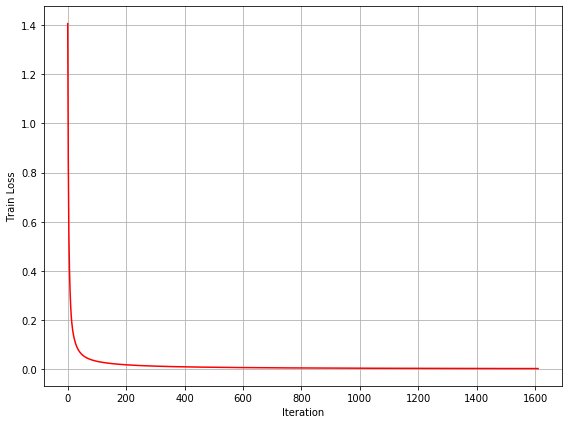

In [126]:
def WNMF(henry_matrix, r, threshold, convergence=1e-5, maxiter=100000, verbose=True):
    n_iter = 0
    train_error_arr = []
    train_error = np.inf
    prev_error = 0
    n_convergence = 0
    n, m = henry_matrix.shape
    
    W = ~np.isnan(henry_matrix)
    U = np.random.rand(n, r)
    V = np.random.rand(r, m)
    WA = np.multiply(W, henry_matrix)
    WA[np.isnan(WA)] = 0.0

    print('U shape: {}\tV shape: {}'.format(U.shape, V.shape))
    while train_error > threshold:
        
        for j in range(r):
            # Move WUV #1 here?
            WUV = np.multiply(W, np.matmul(U,V))
            for i in range(n):
                #WUV = np.multiply(W, np.matmul(U,V))
                U[i,j] = U[i,j] * (np.matmul(WA, np.transpose(V)))[i,j] / (np.matmul(WUV, np.transpose(V)))[i,j]
            # Move WUV #2 here?
            WUV = np.multiply(W, np.matmul(U,V))
            for i in range(m):
                #WUV = np.multiply(W, np.matmul(U,V))
                V[j,i] = V[j,i] * (np.matmul(np.transpose(U), WA))[j,i] / (np.matmul(np.transpose(U), WUV))[j,i] 
            
            if any(np.isnan(U.flatten())):
                raise Exception('''nan's in U''')
            if any(np.isnan(V.flatten())):
                raise Exception('''nan's in V''')
        
        pred = predict_all_v3(U, V, 0.0)[W].flatten()
        actual = henry_matrix[W].flatten()
        
        prev_error = train_error
        train_error = np.sqrt(np.sum([(actual[i] - pred[i])**2 for i in range(len(pred))])/len(pred))
        train_error_arr.append(train_error)
        error_diff = prev_error - train_error
        if n_iter % 1000 == 0:
            print('Train Error on iteration {}: {}\n-------------'.format(n_iter, train_error))
            
        if error_diff < convergence:
            n_convergence += 1
            if n_convergence > 999:
                print('Training has converged after {} iterations. See `convergence` parameter for convergence procedure.'.format(n_iter))
                print('Train error: {}'.format(train_error))
                break
        else:
            n_convergence = 0
        n_iter += 1
        if n_iter > maxiter:
            print('Maximum number of iterations reached.')
            break
    
    fig, ax = plt.subplots(figsize=(8,6))
    #ax.scatter(np.arange(len(train_error_arr)), train_error_arr, color='red')
    ax.plot(np.arange(len(train_error_arr)), train_error_arr, color='red')
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Train Loss')
    plt.grid('on')
    plt.tight_layout()
    plt.show()
    
    return U, V
mu = np.nanmean(henry_df.values)
norm_factors = np.nanmean(henry_df.values, axis=0)

U2, V2 = WNMF(henry_df.values/norm_factors, 20, 1e-5)

In [137]:
h = np.matmul(U2,V2) * norm_factors
#i = random.choice(np.arange(henry_df.shape[0]))
#j = random.choice(np.arange(henry_df.shape[1]))
_i,_j = np.where(np.isnan(henry_df.values))
for _ in range(10):
    idx = random.choice(np.arange(len(_i)))
    i = _i[idx]
    j = _j[idx]
    print('Adsorption of {} in {}'.format(key_to_gas[henry_df.columns[j].split('_')[0]], key_to_material[henry_df.index[i]]))
    print('Prediction: {}'.format(h[i,j]))
    print('Actual value: {}\n'.format(henry_df.values[i,j]))

Adsorption of 1-butene in MOF-74-Ni
Prediction: 303.71220608989097
Actual value: nan

Adsorption of P-Xylene in NU-125
Prediction: 164468.7295608675
Actual value: nan

Adsorption of Krypton in Zeolite ISV
Prediction: 1.721538385924344
Actual value: nan

Adsorption of Krypton in Yb(BPT)(H2O)*(DMF)1.5(H2O)1.25
Prediction: 0.3697799687257708
Actual value: nan

Adsorption of P-Xylene in ZSM-5
Prediction: 11556.780053638116
Actual value: nan

Adsorption of Isobutane in UiO-66
Prediction: 676.7250557060986
Actual value: nan

Adsorption of Ammonia in COF-105
Prediction: 301.3802223870933
Actual value: nan

Adsorption of Krypton in C62H50Cd3K2N2O26
Prediction: 10.378637947605032
Actual value: nan

Adsorption of Ethene in MIL-53(Al)sol.ht
Prediction: 8.948995446987086
Actual value: nan

Adsorption of Toluene in FIR-51
Prediction: 5431.010918246551
Actual value: nan



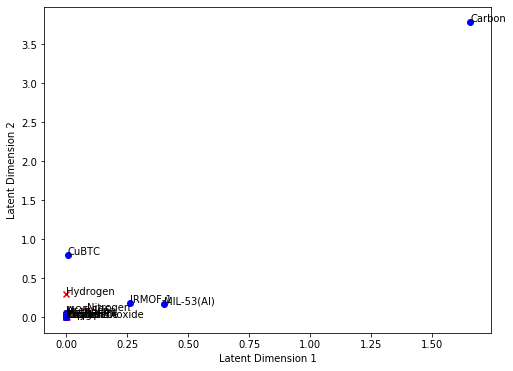

In [129]:
fig, ax = plt.subplots(figsize=(8,6))
n = 8
ax.scatter(U2[:n, 0], U2[:n, 1], color='red', marker='x')
ax.scatter(V2[0,:n], V2[1,:n], color='blue', marker='o')
ax.set_xlabel('Latent Dimension 1')
ax.set_ylabel('Latent Dimension 2')

for i in range(n):
    ax.text(U2[i,0], U2[i,1], key_to_gas[henry_df.columns[i].split('_')[0]])
    ax.text(V2[0,i], V2[1,i], key_to_material[henry_df.index[i]])
plt.show()

In [183]:
def sort_df_by_freq(df):
    row_sum = np.sum(~np.isnan(df.values), axis=1)
    old_row_order = np.arange(len(row_sum))
    new_row_order = sorted(old_row_order, key=lambda x: row_sum[x], reverse=True)
    col_sum = np.sum(~np.isnan(df.values[new_row_order, :]), axis=0)
    old_col_order = np.arange(len(col_sum))
    new_col_order = sorted(old_col_order, key=lambda x: col_sum[x], reverse=True)
    return new_row_order, new_col_order
new_row_order, new_col_order = sort_df_by_freq(henry_df)

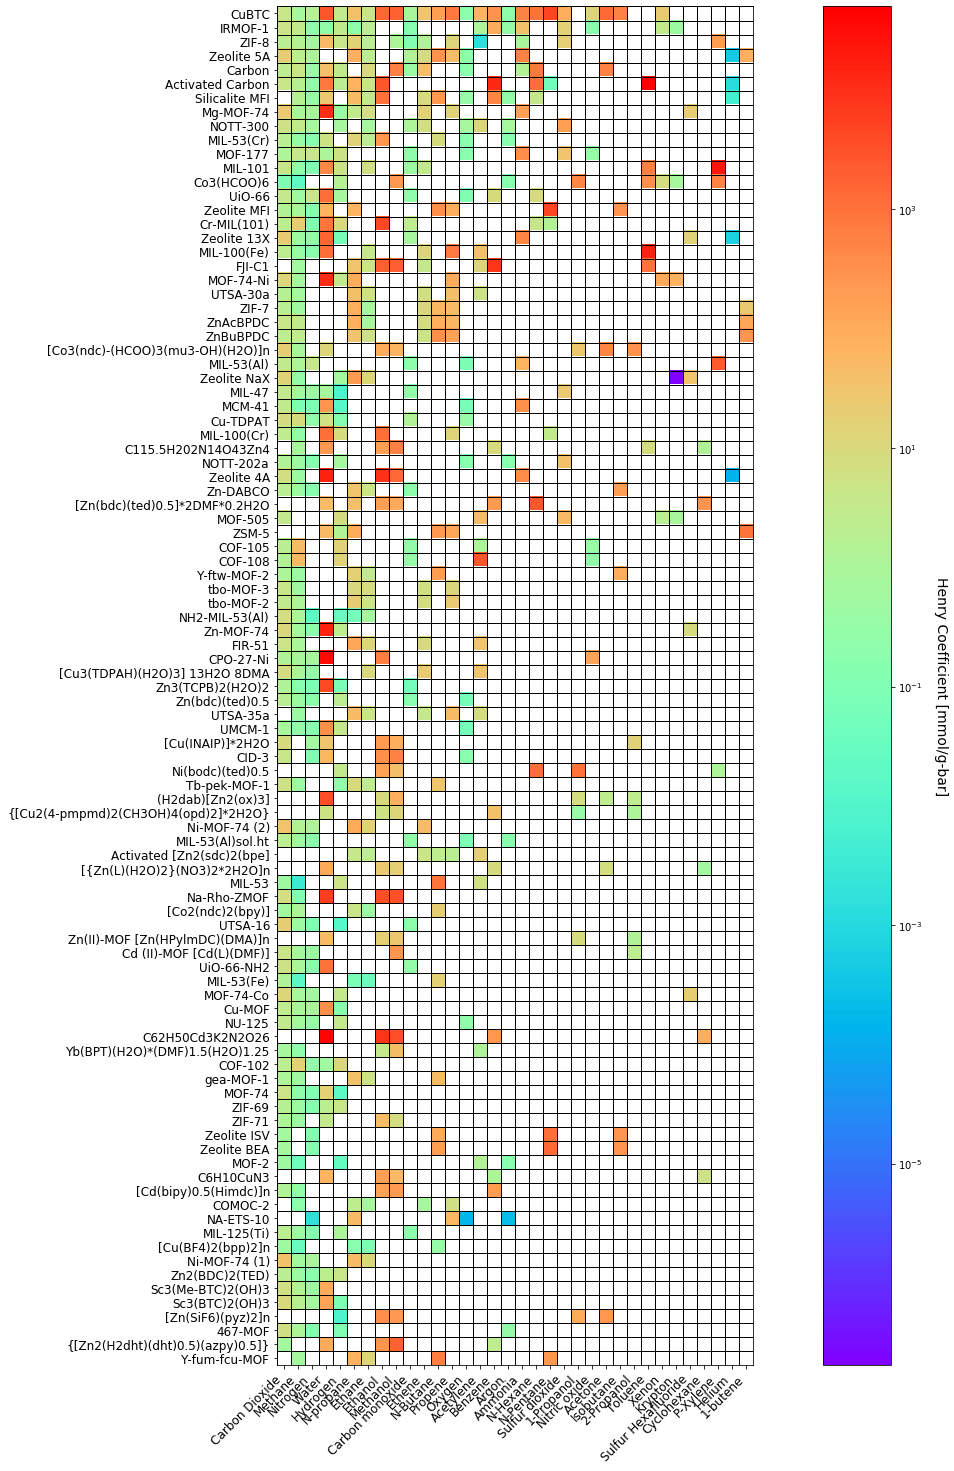

In [195]:
fig = plt.figure(figsize=(25,25))
ax = plt.gca()

for y in range(henry_df.shape[0]):
    plt.plot([0-0.5, henry_df.shape[1]-0.5], [y-0.5, y-0.5], linewidth=1, color='k')
for x in range(henry_df.shape[1]):
    plt.plot([x-0.5, x-0.5], [0-0.5, henry_df.shape[0]-0.5], linewidth=1, color='k')

plt.imshow(henry_df.values[new_row_order, :][:, new_col_order], interpolation='none', cmap='rainbow', norm=matplotlib.colors.LogNorm())
cbar = plt.colorbar()
cbar.set_label('Henry Coefficient [mmol/g-bar]', fontsize=14, rotation=270, labelpad=25)

ax.set_xticks(np.arange(henry_df.shape[1]))
ax.set_xticklabels([key_to_gas[henry_df.columns[i].split('_')[0]] for i in new_col_order], rotation=45, fontsize=12, ha='right')

ax.set_yticks(np.arange(henry_df.shape[0]))
ax.set_yticklabels([key_to_material[henry_df.index[i]] for i in new_row_order], fontsize=12)

plt.show()

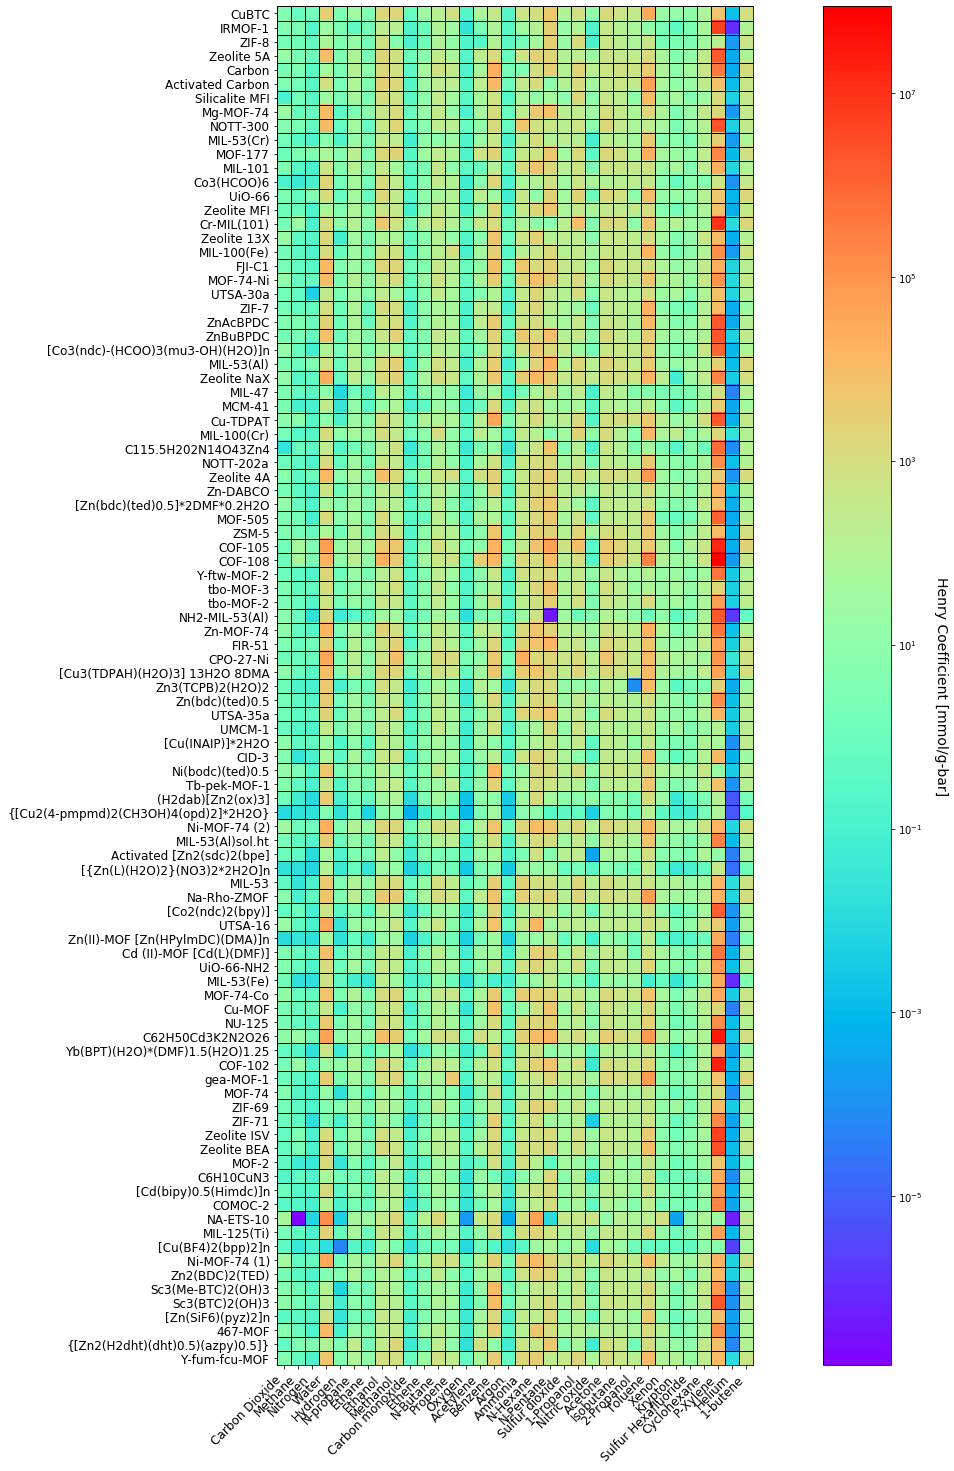

In [196]:
fig = plt.figure(figsize=(25,25))
ax = plt.gca()

for y in range(henry_df.shape[0]):
    plt.plot([0-0.5, henry_df.shape[1]-0.5], [y-0.5, y-0.5], linewidth=1, color='k')
for x in range(henry_df.shape[1]):
    plt.plot([x-0.5, x-0.5], [0-0.5, henry_df.shape[0]-0.5], linewidth=1, color='k')

plt.imshow(h[new_row_order, :][:, new_col_order], interpolation='none', cmap='rainbow', norm=matplotlib.colors.LogNorm())
cbar = plt.colorbar()
cbar.set_label('Henry Coefficient [mmol/g-bar]', fontsize=14, rotation=270, labelpad=25)

ax.set_xticks(np.arange(h.shape[1]))
ax.set_xticklabels([key_to_gas[henry_df.columns[i].split('_')[0]] for i in new_col_order], rotation=45, fontsize=12, ha='right')

ax.set_yticks(np.arange(h.shape[0]))
ax.set_yticklabels([key_to_material[henry_df.index[i]] for i in new_row_order], fontsize=12)

plt.show()

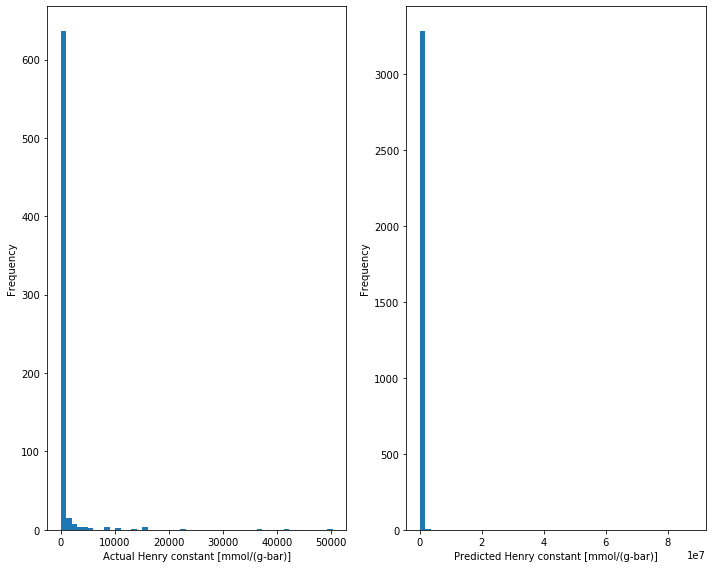

In [130]:
fig, axs = plt.subplots(ncols=2, figsize=(10,8))
axs[0].hist(henry_df.values[~np.isnan(henry_df)].flatten(), bins=50)
axs[0].set_xlabel('Actual Henry constant [mmol/(g-bar)]')
axs[0].set_ylabel('Frequency')

axs[1].hist(h.flatten(), bins=50)
axs[1].set_xlabel('Predicted Henry constant [mmol/(g-bar)]')
axs[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [131]:
max_ind = np.unravel_index(np.argmax(h, axis=None), h.shape)

gas = key_to_gas[henry_df.columns[max_ind[1]].split('_')[0]]
material = key_to_material[henry_df.index[max_ind[0]]]
print('Biggest prediction is {:.2f} mmol/(g-bar)\nGas: {}, Material: {}'.format(h[max_ind], gas, material))


Biggest prediction is 87795861.22 mmol/(g-bar)
Gas: P-Xylene, Material: COF-108
